In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
from era_data import TabletEraDataset
from era_model import EraClassifier
from glob import glob
from era_data import TabletEraDataset
import pandas as pd
from matplotlib import pyplot as plt
from itertools import islice
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm, trange
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression

# Load data and model

In [4]:
! ls lightning_logs

version_727469	version_729970


In [8]:
VERSION_NAME = 'version_729970'

In [9]:
ckpt_fns = glob('lightning_logs/*/checkpoints/*')
ckpt_fns

['lightning_logs/version_727469/checkpoints/epoch=1-step=9650.ckpt',
 'lightning_logs/version_729970/checkpoints/epoch=2-step=18094.ckpt']

In [10]:
CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/version_729970/checkpoints/epoch=2-step=18094.ckpt'

In [11]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN)

/home/kapond/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/kapond/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 595 ms, sys: 277 ms, total: 873 ms
Wall time: 643 ms


In [12]:
model.to(device);

In [13]:
model.eval();

In [14]:
! ls output/clf_ids

era-test-era_clf_bs16_lr5e-05_3epochs-resnet50-103384_samples.csv
era-test-era_clf_bs16_lr5e-05_3epochs-resnet50-97012_samples.csv
era-train-era_clf_bs16_lr5e-05_3epochs-resnet50-103384_samples.csv
era-train-era_clf_bs16_lr5e-05_3epochs-resnet50-97012_samples.csv


In [16]:
train_ids = pd.read_csv(f'output/clf_ids/era-train-era_clf_bs16_lr5e-05_3epochs-resnet50-97012_samples.csv', header=None)[0].astype(str)
test_ids = pd.read_csv(f'output/clf_ids/era-test-era_clf_bs16_lr5e-05_3epochs-resnet50-97012_samples.csv', header=None)[0].astype(str)

In [17]:
len(train_ids), len(test_ids)

(96512, 500)

In [18]:
ds_train = TabletEraDataset(IDS=train_ids)
ds_test = TabletEraDataset(IDS=test_ids)

Filtering 103384 IDS down to provided 96512...
Filtering 103384 IDS down to provided 500...


# Calculate predictions

In [19]:
from itertools import islice
import scipy

In [20]:
# dl_train = DataLoader(ds_train, batch_size=16, shuffle=False, num_workers=1)
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [21]:
def dl2data(dl, MAX_N=None):
    logits = []
    y_true = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            y_true.append(y.numpy())
            logits.append(model(X.to(device)).cpu().numpy())
    y_true = np.hstack(y_true)
    logits = np.vstack(logits)
    return logits, y_true

In [22]:
# logits_train, y_true_train = dl2data(dl_train)

In [23]:
# logits_train.shape, y_true_train.shape

In [24]:
# # calibrate base rates
# %time clf = LogisticRegression().fit(logits_train, y_true_train)

In [25]:
# (clf.predict(logits_train) == y_true_train).mean()

In [26]:
logits, y_true = dl2data(dl_test)

  0%|          | 0/31 [00:00<?, ?it/s]

In [27]:
y_true.shape, logits.shape

((493,), (493, 3))

In [28]:
# (clf.predict(logits) == y_true).mean()

In [29]:
# y_pred = clf.predict(logits)
# y_prob = clf.predict_proba(logits)

In [30]:
y_pred = logits.argmax(axis=-1)
y_prob = scipy.special.softmax(logits, axis=-1)

In [31]:
y_pred.shape, y_prob.shape

((493,), (493, 3))

In [32]:
(y_pred == y_true).mean()

0.9614604462474645

# Check metrics

In [33]:
ERAS = ['early bronze', 'mid/late bronze', 'iron']
ERAS_SHORT = ['EB', 'M/LB', 'Iron']

In [34]:
print(classification_report(y_true, y_pred, target_names=ERAS))

                 precision    recall  f1-score   support

   early bronze       0.97      0.97      0.97       179
mid/late bronze       0.95      0.95      0.95       165
           iron       0.97      0.97      0.97       149

       accuracy                           0.96       493
      macro avg       0.96      0.96      0.96       493
   weighted avg       0.96      0.96      0.96       493



In [35]:
cm = confusion_matrix(y_true, y_pred)
cm # rows: ground truth; cols: prediction

array([[173,   5,   1],
       [  5, 156,   4],
       [  1,   3, 145]])

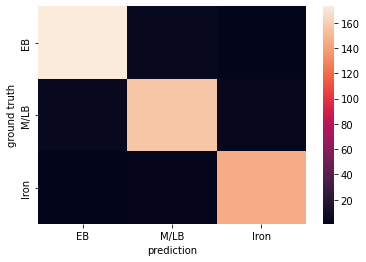

In [36]:
sns.heatmap(cm, xticklabels=ERAS_SHORT, yticklabels=ERAS_SHORT);
plt.xlabel('prediction');
plt.ylabel('ground truth');

In [37]:
for mc in ['ovo', 'ovr']:
    for avg in ['macro', 'weighted']:
        score = roc_auc_score(y_true, y_prob, multi_class=mc, average=avg)
        print(f'{mc} {avg}\t{score:.4f}')

ovo macro	0.9946
ovo weighted	0.9945
ovr macro	0.9944
ovr weighted	0.9942


# Visualize mistakes

In [38]:
mistake_indices = np.where(y_true != y_pred)[0]
mistake_indices

array([ 24,  27,  54,  93,  96, 101, 104, 119, 215, 241, 243, 278, 287,
       320, 412, 419, 420, 428, 459])

In [39]:
mistake_indices.shape

(19,)

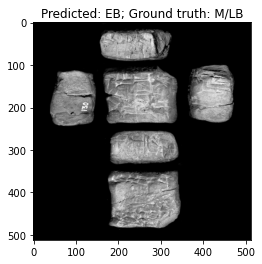

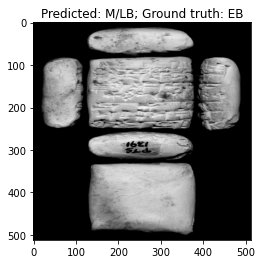

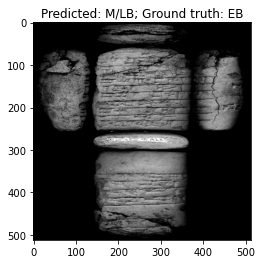

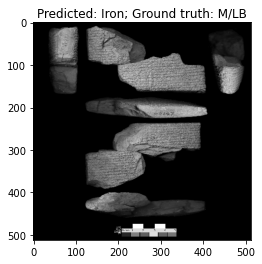

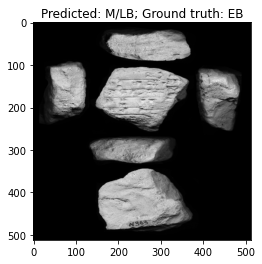

In [40]:
for idx in mistake_indices[:5]:
    
    X, y = ds_test[idx]
    pred = y_pred[idx]
    
    plt.imshow(X, cmap='gray')
    plt.title(f'Predicted: {ERAS_SHORT[pred]}; Ground truth: {ERAS_SHORT[y]}')
    plt.show()

# Explain predictions with Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [42]:
pip install lime

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 275 kB 1.1 MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f52a860630aa62b2c9009ec82aed482cf3bf64a179baee5b42741c3c1cfa6f55
  Stored in directory: /sise/home/kapond/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [44]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [45]:
def preprocess_transform(img):
    return img

In [46]:
def batch_predict(X):
    assert len(X.shape) == 4
    # Lime adds channel dimension (gray2rgb); we remove it
    # it also requires float64 (double) but our model needs float32
    X_gray = X[..., 0].astype(np.float32) / 255
    logits = model(torch.tensor(X_gray).to(device)).detach().cpu().numpy()
#     probs = clf.predict_proba(logits)
    probs = scipy.special.softmax(logits, axis=-1)
    return probs

In [47]:
explainer = lime_image.LimeImageExplainer()

In [48]:
def explain_idx(idx):
    X, y = ds_test[idx]
    
    explanation = explainer.explain_instance(
        X.astype(np.float64) * 255,
        batch_predict,
    #     top_labels=3,
    #     hide_color=0,
        batch_size=16,
        num_samples=1000
    )
    
    top_label = explanation.top_labels[0]
    
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=False,
        num_features=20,
        hide_rest=False
    )
    
    img_boundary = mark_boundaries(temp/255.0, mask)
    
    print(f'Item {idx}:')
    print(f'Ground truth:\t{ERAS_SHORT[y]} ({y})')
    print(f'Prediction:\t{ERAS_SHORT[top_label]} ({top_label})')

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(X, cmap='gray');
    axs[1].imshow(img_boundary);
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 0:
Ground truth:	Iron (2)
Prediction:	Iron (2)


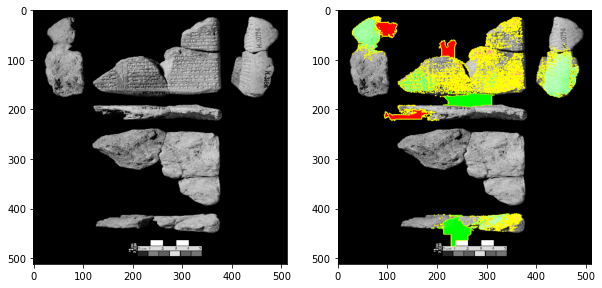

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 1:
Ground truth:	Iron (2)
Prediction:	Iron (2)


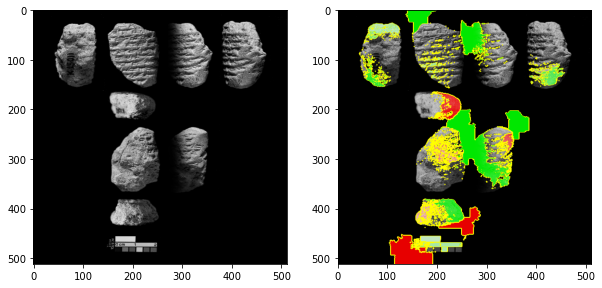

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 2:
Ground truth:	Iron (2)
Prediction:	Iron (2)


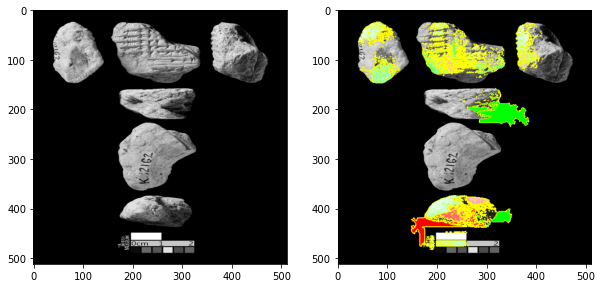

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 3:
Ground truth:	M/LB (1)
Prediction:	M/LB (1)


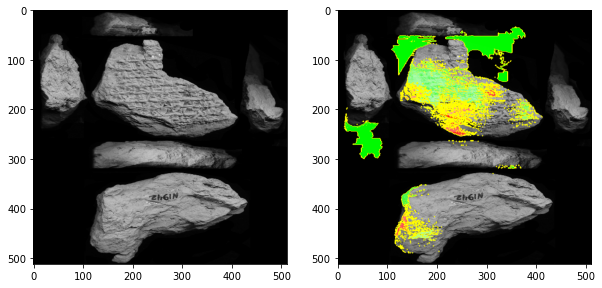

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 4:
Ground truth:	EB (0)
Prediction:	EB (0)


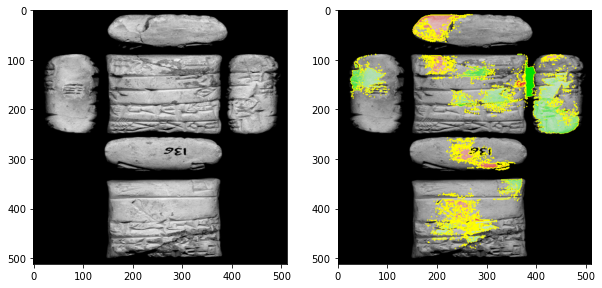

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 5:
Ground truth:	Iron (2)
Prediction:	Iron (2)


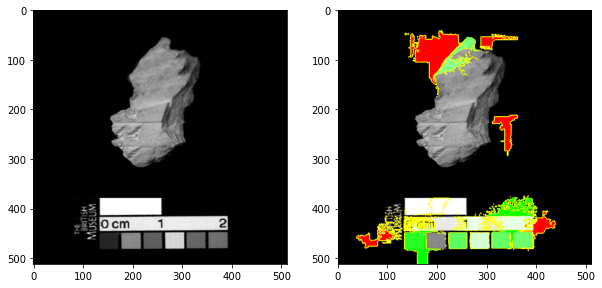

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 6:
Ground truth:	Iron (2)
Prediction:	Iron (2)


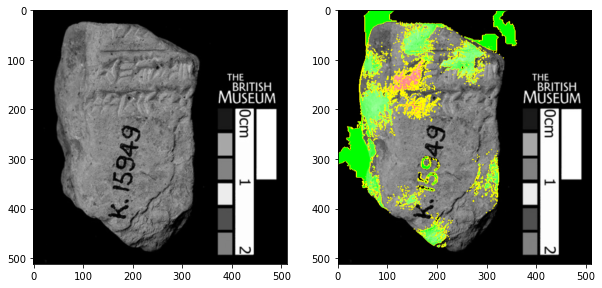

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 7:
Ground truth:	Iron (2)
Prediction:	Iron (2)


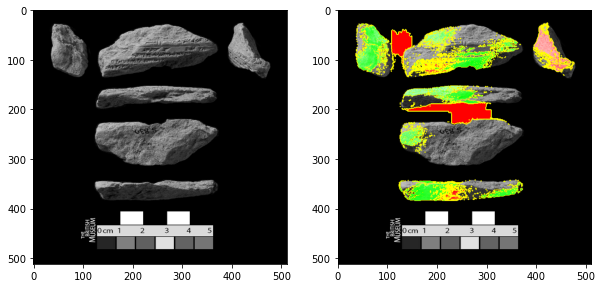

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 8:
Ground truth:	Iron (2)
Prediction:	Iron (2)


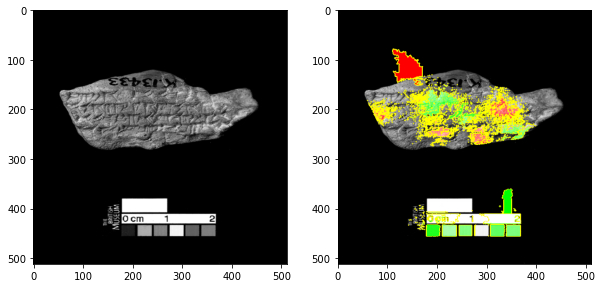

  0%|          | 0/1000 [00:00<?, ?it/s]

Item 9:
Ground truth:	Iron (2)
Prediction:	Iron (2)


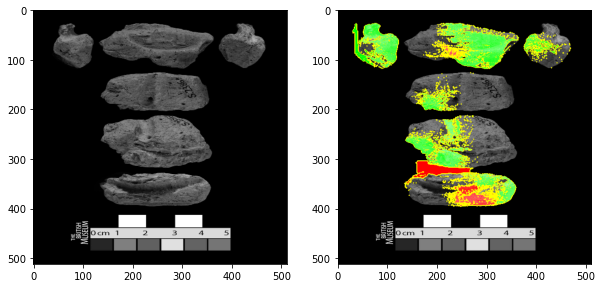

In [49]:
for i in range(10):
    explain_idx(i)